In [ ]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time

import numpy as np
import matplotlib.pyplot as plt

import sys, os

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

me.mechanics_printing()

In [ ]:
def sm_to_matlab_file(sm,p,expr,func_name,file_dir):
    with open(file_dir+f"{func_name}.m",'w') as file:
        file.write(sm._gen_octave(expr,p,func_name).replace(f'function out = {func_name}(U,p)',f'function out = {func_name}(U,x,y,z,p)'))

#### Create Symbols

In [ ]:
from sympy.abc import x,y,z
DoFs = 5          # total degrees of freedom

p = ma.DynamicModelParameters(DoFs)
p.L = ma.ModelSymbol(string = 'L')

p.m = ma.ModelSymbol(string = 'm')
p.I_xx = ma.ModelSymbol(string = 'I_xx')
p.I_yy = ma.ModelSymbol(string = 'I_yy')
p.I_zz = ma.ModelSymbol(string = 'I_zz')

p.m_fwt = ma.ModelSymbol(string = 'm_fwt')
p.l_fwt = ma.ModelSymbol(string = 'l_fwt')

p.Fx = ma.ModelSymbol(string = 'Fx')
p.Fy = ma.ModelSymbol(string = 'Fy')
p.Fz = ma.ModelSymbol(string = 'Fz')


p.Fx_r = ma.ModelSymbol(string = 'Fx_r')
p.Fy_r = ma.ModelSymbol(string = 'Fy_r')
p.Fz_r = ma.ModelSymbol(string = 'Fz_r')

p.Fx_l = ma.ModelSymbol(string = 'Fx_l')
p.Fy_l = ma.ModelSymbol(string = 'Fy_l')
p.Fz_l = ma.ModelSymbol(string = 'Fz_l')


# Attitude Parmas
# p.rho = ma.ModelSymbol(value = 1.225,string = 'rho')                 # density
# p.V = ma.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.alpha  = ma.ModelSymbol(value = 0,string = 'alpha')                     # gravity
p.Lambda  = ma.ModelSymbol(value = 0,string = 'Lambda')                     # gravity
p.theta  = ma.ModelSymbol(value = 0,string = 'theta')                     # gravity
p.b  = ma.ModelSymbol(value = 1,string = 'b')                     # gravity

#### Create Coordinate Systems

In [22]:
tether_frame = ma.HomogenousTransform().R_z(p.q[0]).R_x(-p.q[1]+sym.pi).Translate(0,0,p.L)
tether2body = ma.HomogenousTransform().R_x(p.q[2]).R_z(p.q[4]).R_y(p.q[3])
body_frame = (tether_frame*tether2body).simplify()
body2fwtr = body_frame.Translate(0,p.b,0).R_x(-p.theta).Translate(0,p.l_fwt,0)
fwt_frame_l = body_frame.Translate(0,-p.b,0).R_x(p.theta).Translate(0,-p.l_fwt,0)
#Generate Mass Matrices
M = ele.MassMatrix(p.m, I_xx = 0, I_yy=0, I_zz=0)
M_fwt = ele.MassMatrix(p.m_fwt, I_xx = 0, I_yy=0, I_zz=0)

# Generate Rigid Elements
aircraft_mass = ele.RigidElement(tether_frame,M,gravityPotential=True, simplify=True)
fwt_mass_r = ele.RigidElement(fwt_frame_r,M_fwt,gravityPotential=True, simplify=False)
fwt_mass_l = ele.RigidElement(fwt_frame_l,M_fwt,gravityPotential=True, simplify=False)
#tether_spring = ele.Spring(p.q[2],p.K)

aircraft_forces = ef.BodyForce(p,tether_frame,Fx=p.Fx,Fy=p.Fy,Fz=p.Fz)

In [59]:
centri = body_frame.Transform_point([x,y,z]).diff(me.dynamicsymbols._t,2)
test = body_frame.Inverse().Transform_vector(sym.Matrix([0,0,-p.g])-centri)

In [70]:
centri = body_frame.Transform_point([0,p.l_fwt,0]).diff(me.dynamicsymbols._t,2)
test = body_frame.Inverse().Transform_vector(sym.Matrix([0,0,-p.g])-centri)

In [71]:
test = test*p.m_fwt
force = ef.BodyForce(p,tether_frame,Fx=test[0],Fy=test[1],Fz=test[2])

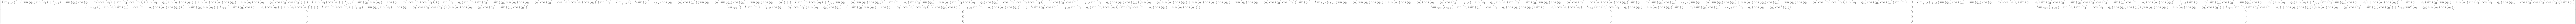

In [76]:
force.Q().jacobian(p.qdd)

In [61]:
centri = body_frame.Transform_point([0,p.l_fwt,0]).diff(me.dynamicsymbols._t,2)
test = body_frame.Inverse().Transform_vector(sym.Matrix([0,0,-p.g])-centri)
qd = p.q.diff(me.dynamicsymbols._t)
qdd = p.q.diff(me.dynamicsymbols._t,2)
qdd2 = p.qd.diff(me.dynamicsymbols._t)
x_subs = {**{qdd[i]:p.qdd for i in range(len(qd))},**{qdd2[i]:p.qdd for i in range(len(qd))},**{qd[i]:p.qd[i] for i in range(len(qd))}  }
test = me.msubs(test,x_subs)
M_fwt = test.jacobian(p.qdd)

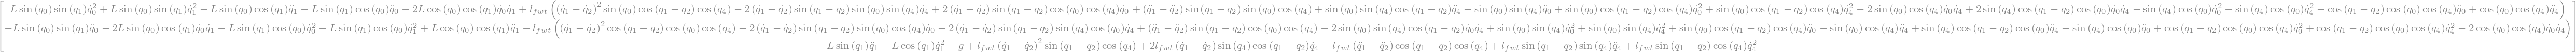

In [67]:
sym.Matrix([0,0,-p.g])-centri

In [77]:
centri = body_frame.Transform_point([0,p.l_fwt,0]).diff(me.dynamicsymbols._t,2)
test = body_frame.Inverse().Transform_vector(sym.Matrix([0,0,-p.g])-centri)
qd = p.q.diff(me.dynamicsymbols._t)
qdd = p.q.diff(me.dynamicsymbols._t,2)
qdd2 = p.qd.diff(me.dynamicsymbols._t)
x_subs = {**{qdd[i]:0 for i in range(len(qd))},**{qdd2[i]:0 for i in range(len(qd))},**{qd[i]:p.qd[i] for i in range(len(qd))}  }
test = me.msubs(test,x_subs)
centri = me.msubs(centri,x_subs)
R = body_frame.Inverse().E

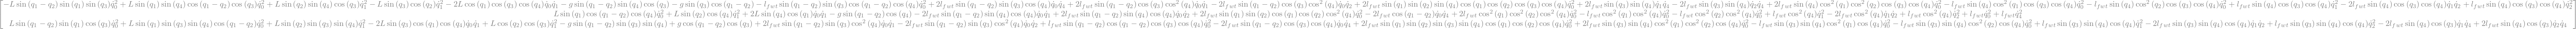

In [79]:
sym.simplify(test)

In [56]:
file_dir = "C:\\Git\\AlbatrossOneNastran\\matlab\\+accel_test\\"
sm_to_matlab_file(sm,p,test,'get_a',file_dir)
sm_to_matlab_file(sm,p,centri,'get_centri',file_dir)
sm_to_matlab_file(sm,p,R,'get_R',file_dir)
p.to_matlab_class(file_dir=file_dir)

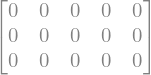

In [4]:
# Generate Aircraft Forces
aircraft_forces = ef.BodyForce(p,tether_frame,Fx=p.Fx,Fy=p.Fy,Fz=p.Fz)
aircraft_inertia = ef.BodyForce(p,tether2body,Mx=-p.I_xx*p.qdd[2],My=-p.I_yy*p.qdd[3],Mz=-p.I_zz*p.qdd[4])
forces = ef.CompositeForce([aircraft_forces,aircraft_inertia])

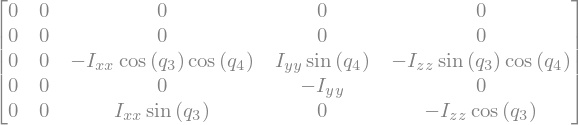

In [7]:
aircraft_inertia_force = ef.BodyForce(p,tether2body,Mx=-p.I_xx*p.qdd[2],My=-p.I_yy*p.qdd[3],Mz=-p.I_zz*p.qdd[4]).Q()
wingtip_inertia_force

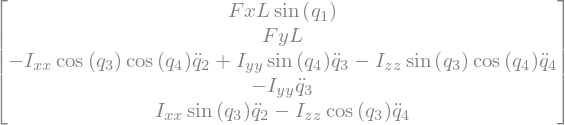

In [5]:
test = ef.CompositeForce([aircraft_forces,aircraft_inertia])
test.Q()

In [19]:
sm = ma.SymbolicModel.FromElementsAndForces(p,[aircraft_mass],ExtForces=aircraft_forces)

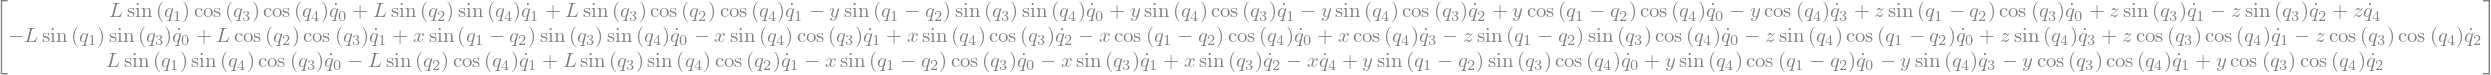

In [6]:
v_body = body_frame.Translate(x,y,z).simplify().BodyVelocity()
vb = sym.simplify(sym.Matrix(v_body[0:3]))
vb

In [16]:
def sm_to_matlab_file(sm,p,expr,func_name,file_dir):
    with open(file_dir+f"{func_name}.m",'w') as file:
        file.write(sm._gen_octave(expr,p,func_name).replace(f'function out = {func_name}(U,p)',f'function out = {func_name}(U,x,y,z,p)'))

In [8]:
file_dir = "C:\\Git\\AlbatrossOneNastran\\matlab\\+gen_vlm\\+TetheredFlight\\"
sm_to_matlab_file(sm,p,vb,'get_V',file_dir)
p.to_matlab_class(file_dir=file_dir)

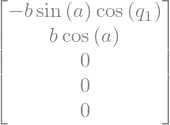

In [89]:
from sympy.abc import a,b,c,d,e,f,g,x,y,z

test_frame = tether_frame = ma.HomogenousTransform().R_x(p.q[0]).R_y(p.q[1]).Translate(0,1,0).R_z(a)

jb = test_frame.BodyJacobian(p.q)
wrench = sym.Matrix([0,0,0,0,b,0])
sym.simplify(jb.T*wrench)

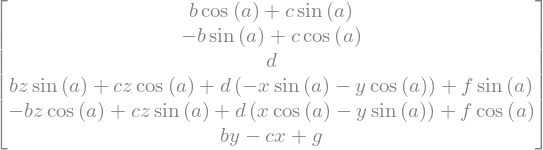

In [95]:
test_frame = ma.HomogenousTransform().Translate(x,y,z).R_z(a)
test_frame.Adjoint().T*sym.Matrix([b,c,d,0,f,g])